# Augmentations on hand gestures dataset

#### Import libraries

In [1]:
import glob
import itertools
import json
import os
import re

import mrob
import numpy as np
import open3d as o3d

import matplotlib.pyplot as plt

#### Set filenames

In [2]:
DATA_DIR = "data_demo"
SET_DIR = "set_5_rotate"
CAMERAS_DIR = ["cam_center", "cam_right", "cam_left"]  # front, right, left (really not matter)

CALIBRATION_DIR = os.path.join(DATA_DIR, "calib_params")
CALIBRATION_INTRINSIC = {
    "cam_center" : "1m.json",
    "cam_right" : "2s.json",
    "cam_left" : "9s.json",
}
CALIBRATION_EXTRINSIC = {
    ("cam_center", "cam_right") : os.path.join("1-2", "calibration_blob.json"),
    ("cam_center", "cam_left") : os.path.join("1-9", "calibration_blob.json"),
    ("cam_right", "cam_left") : os.path.join("2-9", "calibration_blob.json"),
}

RENDER_OPTION = "render_option.json"

main_camera_index = 0

## Functional part

#### Read images

Map images indexes by timestamps

Get a list of indexes for each frame from main stream that are nearest by timestamps

In [3]:
def find_timestamp(s):
    """
    Returns indexes of start and the end (negative) of the longest numerical sequence
    
    Parameters:
    s (str): string with numerical timestamp

    Returns:
    timestamp_index (list[int]): start and end (negative) of the timestamp sequence
    """
    longest = max(re.findall(r'\d+', s), key=len)
    start = s.find(longest)
    
    timestamp_index = [start, start + len(longest) - len(s)]

    return timestamp_index


def map_nearest(cameras_filenames, main_camera_index=0):
    """
    Returns an array [L x N] of indexes that matches every i frame (along L)
    from main camera to the nearest frame from other cameras by timestamps
    All filenames should contain timestamps and be sorted by them
    N = number of cameras
    L = number of filenames in cameras_filenames[main_camera_index]

    Parameters:
    cameras_filenames (Sequence[Sequence[str]]): filenames from N cameras
    main_camera_index (int, default=0): main camera index

    Returns:
    nearest (np.ndarray[int]): indexes of filenames that are nearest to i frame from main camera
    """
    assert all(cameras_filenames)
    
    nearest = np.zeros((len(cameras_filenames[main_camera_index]), len(cameras_filenames)), dtype=np.int64)
    pointers = np.zeros(len(cameras_filenames), dtype=np.int64)

    patterns = np.array([find_timestamp(filenames[0]) for filenames in cameras_filenames], dtype=np.int64)

    for i, main_filename in enumerate(cameras_filenames[main_camera_index]):
        now = int(main_filename[patterns[main_camera_index, 0]:patterns[main_camera_index, 1]])

        for j, (pointer, filenames) in enumerate(zip(pointers, cameras_filenames)):
            now_camera = int(filenames[pointer][patterns[j, 0]:patterns[j, 1]])

            while pointer + 1 < len(filenames) and \
                    now - now_camera > int(filenames[pointer + 1][patterns[j, 0]:patterns[j, 1]]) - now:
                pointer += 1
                now_camera = int(filenames[pointer][patterns[j, 0]:patterns[j, 1]])
            
            nearest[i, j] = pointer
    
    return nearest

#### Read calibration

In [4]:
def get_intrinsics(filenames):
    """
    Returns a list [2*N x 6] of calibration parameters for color and depth cameras
    in form of open3d.camera.PinholeCameraIntrinsic from JSON files
    [width, height, fx, fy, cx, cy]
    N = number of filenames

    Parameters:
    filenames (Sequence[str]): JSON filenames containing calibration

    Returns:
    intrinsics (np.ndarray[float]): calibration parameters
    """
    assert all(filenames)

    intrinsics = np.zeros((2 * len(filenames), 6), dtype=np.float64)

    for i, filename in enumerate(filenames):
        with open(filename) as json_file:
            data = json.load(json_file)

        for j, camera in enumerate(("color", "depth")):
            intrinsics[2 * i + j] = [
                data[f"{camera}_camera"]["resolution_width"],
                data[f"{camera}_camera"]["resolution_height"],
                data[f"{camera}_camera"]["intrinsics"]["parameters"]["parameters_as_dict"]["fx"],
                data[f"{camera}_camera"]["intrinsics"]["parameters"]["parameters_as_dict"]["fy"],
                data[f"{camera}_camera"]["intrinsics"]["parameters"]["parameters_as_dict"]["cx"],
                data[f"{camera}_camera"]["intrinsics"]["parameters"]["parameters_as_dict"]["cy"],
            ]

    return intrinsics


def get_extrinsics(filenames):
    """
    Returns a list [N x 4 x 4] of transforms
    N = number of filenames

    Parameters:
    filenames (Sequence[str]): JSON filenames containing calibration

    Returns:
    extrinsics (np.ndarray[float]): relative calibration parameters
    """
    assert all(filenames)

    extrinsics = np.zeros((len(filenames), 4, 4), dtype=np.float64)

    for i, filename in enumerate(filenames):
        with open(filename) as json_file:
            data = json.load(json_file)

        T = np.eye(4)
        T[:3, :3] = np.array(data['CalibrationInformation']['Cameras'][1]['Rt']['Rotation']).reshape(3, 3)
        T[:3, 3] = np.array(data['CalibrationInformation']['Cameras'][1]['Rt']['Translation'])

        extrinsics[i] = T

    return extrinsics

#### Transform Depth image on Color image

TODO (currently provided by dataset)

NOTE: better to pre-process this step rather to integrate in pipeline

#### Create Point clouds

NOTE: better to pre-process this step rather to integrate in pipeline

In [5]:
def get_rgbd_images(images_paths, depth_scale=1000, depth_trunc=5.0):
    """
    Returns a list [N // 2] of open3d.geometry.RGBDImage
    Input list should contain paths in the same order as all pipeline
    N = number of paths

    Parameters:
    images_paths (Sequence[str]): filenames for color and depth images
    depth_scale (float, default=1000.0): ratio to scale depth
    depth_trunc (float, default=5.0): values larger depth_trunc gets truncated.
        The depth values will first be scaled and then truncated.

    Returns:
    rgbd_images (list[open3d.geometry.RGBDImage]): RGB-D images
    """
    assert all(images_paths)
    assert len(images_paths) % 2 == 0
    
    rgbd_images = [[] for _ in range(len(images_paths) // 2)]

    for i in range(len(rgbd_images)):
        rgbd_images[i] = o3d.geometry.RGBDImage.create_from_color_and_depth(
            color=o3d.io.read_image(images_paths[2 * i]),
            depth=o3d.io.read_image(images_paths[2 * i + 1]),
            depth_scale=depth_scale,
            depth_trunc=depth_trunc,
            convert_rgb_to_intensity=False
        )
    
    return rgbd_images


def create_point_clouds(rgbd_images, intrinsics, extrinsics):
    """
    Returns a list [N] of open3d.geometry.PointCloud
    Input list should contain RGB-D images as open3d.geometry.RGBDImage
    All inputs should have the same shape
    N = number of images

    Parameters:
    rgbd_images (Sequence[open3d.geometry.RGBDImage]): RGB-D images
    intrinsics (np.ndarray[float]): intrinsics of RGB-D images
    extrinsics (np.ndarray[float]): extrinsics of RGB-D images

    Returns:
    rgbd_images (list[open3d.geometry.RGBDImage]): RGB-D images
    """
    assert len(rgbd_images) == len(intrinsics) == len(extrinsics)
    assert all(rgbd_images)

    point_clouds = [[] for _ in range(len(rgbd_images))]
    to_filter = [1, 1, 0, 0, 0, 0]

    for i in range(len(point_clouds)):
        point_clouds[i] = o3d.geometry.PointCloud.create_from_rgbd_image(
            image=rgbd_images[i],
            intrinsic=o3d.camera.PinholeCameraIntrinsic(
                *map(lambda val: int(val[1]) if to_filter[val[0]] else val[1], enumerate([*intrinsics[i]]))
            ),
            extrinsic=np.linalg.inv(extrinsics[i]),
            project_valid_depth_only=True
        )
    
    return point_clouds

#### Concatenate Point clouds

In [6]:
def concatenate_point_clouds(point_clouds):
    """
    Returns concateneted point cloud from list of point clouds

    Parameters:
    point_clouds (Sequence[open3d.geometry.PointCloud]): list of point clouds

    Returns:
    concatenated_point_cloud (open3d.geometry.PointCloud): concatenated point cloud
    """
    concatenated_point_cloud = np.sum(point_clouds)
    
    return concatenated_point_cloud

#### Supportive functions to get matrices

In [7]:
def get_intrinsic_matrix(fx, fy, cx, cy):
    """
    Returns an intrinsic matrix from list of parameters

    Parameters:
    fx (float): focal x in pixels
    fy (float): focal y in pixels
    cx (float): principal point x in pixels
    cy (float): principal point y in pixels

    Returns:
    intrinsic_matrix (np.ndarray[float]): intrinsic matrix
    """
    intrinsic_matrix = np.array([
        [fx, 0., cx, 0.],
        [0., fy, cy, 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]
    ], dtype=np.float64)

    return intrinsic_matrix


def get_extrinsic_matrix(angle, z_target):
    """
    Returns an extrinsic matrix for new camera position from list of parameters
    Camera position calculates as rotation around X-axis shifted by Z on z_target
    So, camera rotates around z_target point

    Parameters:
    angle (float): angle of rotation in radians
    z_target (float): z-coornate of point of rotation

    Returns:
    extrinsic_matrix (np.ndarray[float]): extrinsic matrix
    """
    extrinsic_matrix = np.array([
        [1., 0., 0., 0.],
        [0., np.cos(angle), -np.sin(angle), z_target * np.sin(angle)],
        [0., np.sin(angle), np.cos(angle), z_target * (1 - np.cos(angle))],
        [0., 0., 0., 1.],
    ], dtype=np.float64)

    return extrinsic_matrix


def randomize_extrinsic(extrinsic_matrix, scale):
    """
    Returns matrix with applied random normal (mean=0, var=var)
    variations on state vector [th1, th2, th3, x, y, z] using mrob
    
    Parameters:
    extrinsic_matrix (np.ndarray[float]): extrinsic parameters of camera [4 x 4]
    scale (float or Sequence[float]): standard deviation, can be array of 6 floats

    Returns:
    randomized_extrinsic_matrix (np.ndarray[float]): randomized extrinsic matrix
    """
    T = mrob.geometry.SE3(extrinsic_matrix)
    
    randomized_vector = T.Ln() + np.random.normal(loc=0, scale=scale, size=(6))
    randomized_extrinsic_matrix = mrob.geometry.SE3(randomized_vector).T()

    return randomized_extrinsic_matrix

#### Project Point clouds

In [8]:
def filter_by_image_size(point_cloud_data, width, height):
    """
    Returns an array of points that are inside given image size

    Parameters:
    point_cloud_data (np.ndarray[float]): numpy array representation of point cloud
    width (int): image width
    height (int): image height

    Returns:
    filtered_point_cloud_data (np.ndarray[float]): numpy array representation of point cloud
    """
    point_cloud_index = (
        (0 <= point_cloud_data[:, 0]) *
        (point_cloud_data[:, 0] < width) *
        (0 <= point_cloud_data[:, 1]) * 
        (point_cloud_data[:, 1] < height)
    )
    filtered_point_cloud_data = point_cloud_data[point_cloud_index]

    return filtered_point_cloud_data


def project_point_clouds(point_cloud, K, T, width, height):
    """
    Projects point cloud on image with given camera parameters and image size
    Projection goes on camera shifted by angle around z_target point in YZ-plane
    Returns projected image as numpy array

    Parameters:
    point_cloud (open3d.geometry.PointCloud): point cloud to project
    K (np.ndarray[float]): camera intrinsic matrix [4 x 4]
    T (np.ndarray[float]): camera extrinsic matrix [4 x 4]
    width (int): width of the image
    height (int): height of the image

    Returns:
    image_projected (np.ndarray[float]): projected image
    """
    # Create a copy
    point_cloud = o3d.geometry.PointCloud(point_cloud)

    point_cloud.transform(K @ np.linalg.inv(T))

    point_cloud_data = np.hstack([np.asarray(point_cloud.points), np.asarray(point_cloud.colors)])

    # point_cloud_data = point_cloud_data[point_cloud_data[:, 2] > 1.4]

    point_cloud_data.view('i8,i8,i8,i8,i8,i8').sort(order=['f2'], axis=0)
    point_cloud_data = point_cloud_data[::-1]
    point_cloud_data[:, :3] /= point_cloud_data[:, 2].reshape(-1, 1)

    filtered_point_cloud_data = filter_by_image_size(point_cloud_data, width, height)

    image_projected = np.zeros((height, width, 3))
    image_projected[filtered_point_cloud_data[:, 1].astype(np.int16),
                filtered_point_cloud_data[:, 0].astype(np.int16)] = filtered_point_cloud_data[:, 3:]
    
    return image_projected

## Overall pipeline

Read images and calibration files

In [9]:
# list of [..., CAMERAS_DIR[i - 1]/depth/*.png, CAMERAS_DIR[i]/color/*.jpg, CAMERAS_DIR[i]/depth/*.png, ...]
images_paths = [sorted(glob.glob(os.path.join(DATA_DIR, SET_DIR, camera, type, '*')))
    for camera, type in itertools.product(CAMERAS_DIR, ('color', 'depth'))]
mapped_indexes = map_nearest(images_paths, main_camera_index)

intrinsics_paths = [os.path.join(CALIBRATION_DIR, CALIBRATION_INTRINSIC[camera])
    for camera in CAMERAS_DIR]
intrinsics = get_intrinsics(intrinsics_paths)

extrinsics_paths = [os.path.join(CALIBRATION_DIR, CALIBRATION_EXTRINSIC[camera])
    for camera in itertools.combinations(CAMERAS_DIR, 2)]
extrinsics = get_extrinsics(extrinsics_paths)

render_option_path = os.path.join(DATA_DIR, RENDER_OPTION)

New view settings

In [10]:
angle = np.deg2rad(30)
z_target = 1.25

K = get_intrinsic_matrix(*intrinsics[main_camera_index, 2:])
T = get_extrinsic_matrix(angle, z_target)

scale = [0., 0., 0., 0., 0., 0.]
T_randomized = randomize_extrinsic(T, scale)

Renderer settings

In [11]:
*image_size, = map(int, intrinsics[main_camera_index, :2])

vis = o3d.visualization.Visualizer()
vis.create_window(width=image_size[0], height=image_size[1])

vis.get_render_option().load_from_json(render_option_path)
# render_options = vis.get_render_option()
# render_options.point_color_option = o3d.visualization.PointColorOption.Color
# render_options.point_size = 1.5
# render_options.background_color = [0., 0., 0.]
# render_options.save_to_json(render_option_path)

camera = o3d.camera.PinholeCameraParameters()

camera.extrinsic = np.linalg.inv(T_randomized)

to_filter = [1, 1, 0, 0, 0, 0]
camera.intrinsic = o3d.camera.PinholeCameraIntrinsic(
                *map(lambda val: int(val[1]) if to_filter[val[0]] else val[1],
                     enumerate([*intrinsics[main_camera_index]]))
            )

view_control = vis.get_view_control()

Create, Concatenate Point clouds and Project on new View

In [33]:
# i = 50
# group = mapped_indexes[i]
# while True:
for group in mapped_indexes:
    paths = [''] * len(group)
    for i, index in enumerate(group):
        paths[i] = images_paths[i][index]
    
    rgbd_images = get_rgbd_images(
        paths,
        depth_scale=1000,
        depth_trunc=2.0
    )

    point_clouds = create_point_clouds(
        rgbd_images,
        intrinsics[::2],
        np.concatenate([[np.eye(4)], extrinsics[:len(CAMERAS_DIR) - 1]])
    )
    
    pc_concatenated = concatenate_point_clouds(point_clouds)
    
    # Filter outliers
    pc_concatenated, _ = pc_concatenated.remove_radius_outlier(10, 0.01)

    # Option 1:
    # Render Point cloud
    vis.add_geometry(pc_concatenated)

    view_control.convert_from_pinhole_camera_parameters(camera, True)

    vis.poll_events()
    vis.update_renderer()
    rendered_image = vis.capture_screen_float_buffer(do_render=True)
    vis.clear_geometries()

    # Option 2:
    # Image recieved by manual projection without rendering
    image_projected = project_point_clouds(pc_concatenated, K, T_randomized, *map(int, intrinsics[0, :2]))

    # plt.imsave(f"outputs/rendered_{str(group[0]).zfill(8)}.jpg", np.asarray(rendered_image))
    break

# import subprocess
# subprocess.run(["ffmpeg", "-framerate", "30", "-i", "outputs/rendered_00000%03d.jpg", "rendered.mp4"]);

After everything is done the visualization window should be destroyed

In [39]:
vis.destroy_window()

Plot rendered Point cloud

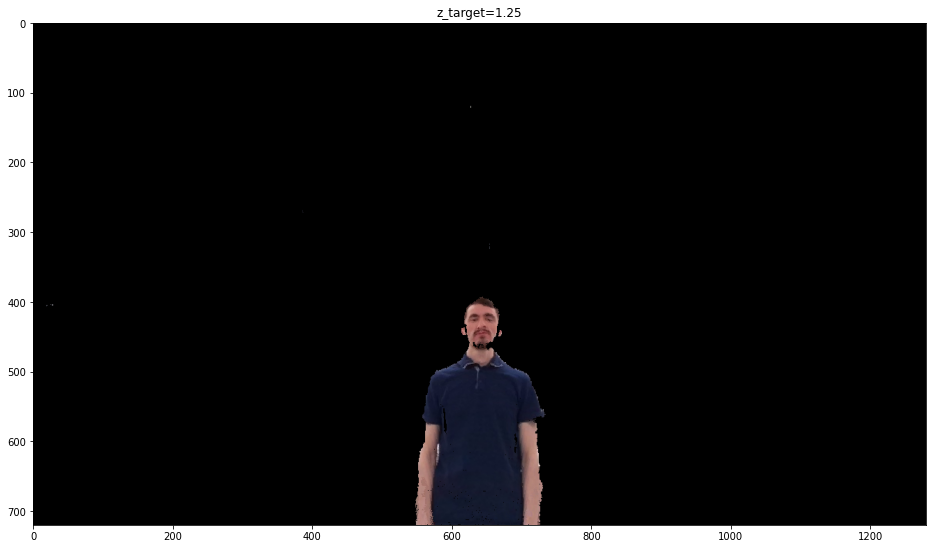

In [34]:
plt.figure(figsize=(16, 10))
plt.title(f"{z_target=}")
plt.imshow(np.asarray(rendered_image));
# plt.savefig(f"outputs/{z_target}_filtered.jpg", bbox_inches='tight')

Plot manual projected Point cloud

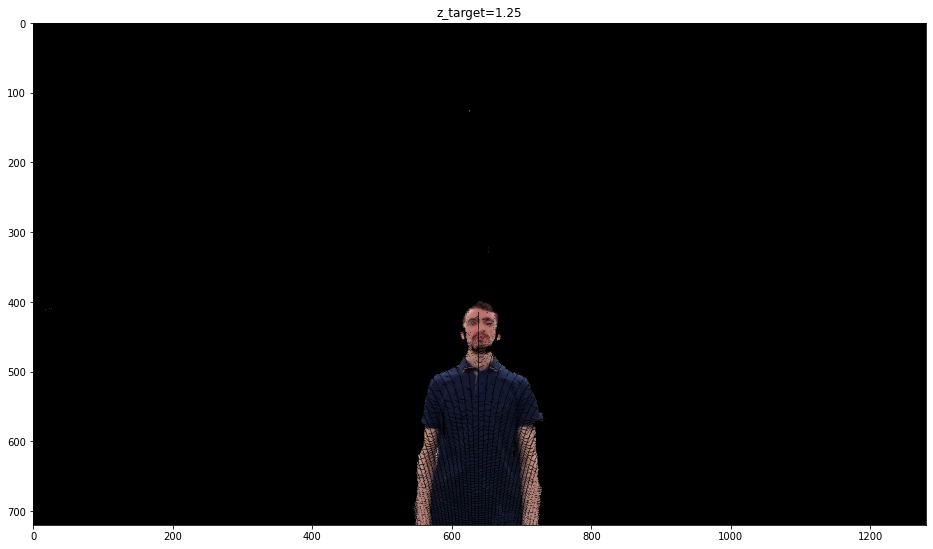

In [35]:
plt.figure(figsize=(16, 10))
plt.title(f"{z_target=}")
plt.imshow(image_projected);
# plt.savefig(f"outputs/{z_target}_filtered.jpg", bbox_inches='tight')

Plot image without transformation

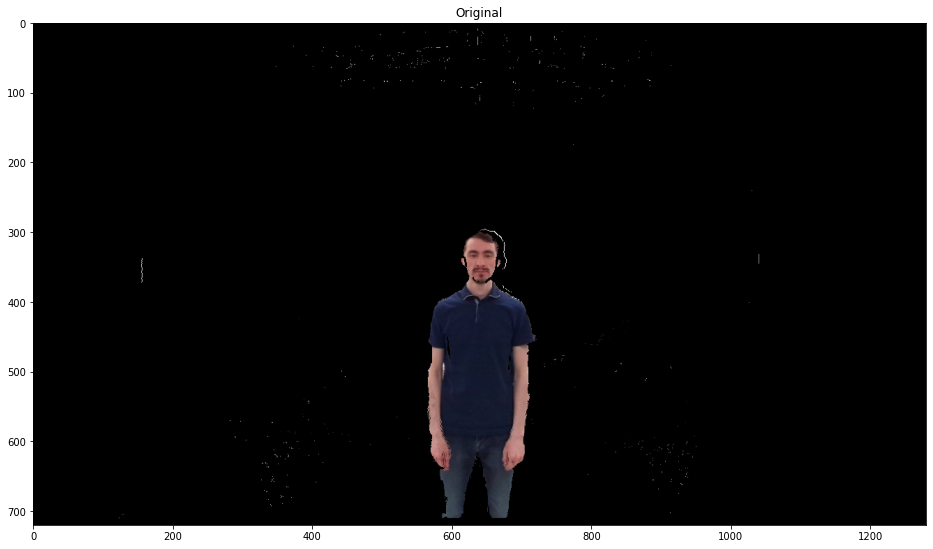

In [36]:
image_projected_orig = project_point_clouds(pc_concatenated, K, np.eye(4), *map(int, intrinsics[0, :2]))

plt.figure(figsize=(16, 10))
plt.title("Original")
plt.imshow(image_projected_orig);
# plt.savefig("outputs/Original_filtered.jpg", bbox_inches='tight')

## Plotly visualization

Visualization of concatenated Point cloud

In [37]:
import plotly.graph_objects as go

In [38]:
depth_points = np.asarray(pc_concatenated.points)
colors_points = np.asarray(pc_concatenated.colors)

step = 10

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=depth_points[::step, 0],
            y=depth_points[::step, 1],
            z=depth_points[::step, 2],
            mode='markers',
            marker=dict(size=1, color=colors_points[::step])
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True)
        )
    )
)
fig.show()